In [1]:
!git clone https://github.com/utkuozbulak/pytorch-cnn-visualizations

Cloning into 'pytorch-cnn-visualizations'...
remote: Enumerating objects: 880, done.
remote: Counting objects: 100% (110/110), done.
remote: Compressing objects: 100% (98/98), done.
remote: Total 880 (delta 46), reused 50 (delta 12), pack-reused 770
Receiving objects: 100% (880/880), 7.85 MiB | 23.44 MiB/s, done.
Resolving deltas: 100% (434/434), done.


In [ ]:
!pip install --upgrade wandb
import wandb

In [3]:
!wget --header="Host: storage.googleapis.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/99.0.4844.51 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Referer: https://wandb.ai/" "https://storage.googleapis.com/wandb_datasets/nature_12K.zip" -c -O 'nature_12K.zip'

--2022-03-30 18:42:20--  https://storage.googleapis.com/wandb_datasets/nature_12K.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.197.128, 173.194.198.128, 64.233.191.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.197.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3816687935 (3.6G) [application/zip]
Saving to: ‘nature_12K.zip’

nature_12K.zip      100%[===================>]   3.55G   156MB/s    in 26s     

2022-03-30 18:42:46 (141 MB/s) - ‘nature_12K.zip’ saved [3816687935/3816687935]



In [4]:
!unzip "/content/nature_12K.zip"

Streaming output truncated to the last 5000 lines.
  inflating: inaturalist_12K/train/Arachnida/1ac25349af662e85f577a31f64beca41.jpg  
  inflating: inaturalist_12K/train/Arachnida/117ef7f1812725f359500448a258e713.jpg  
  inflating: inaturalist_12K/train/Arachnida/6409254954c3b46d88d64f0bf4c632fa.jpg  
  inflating: inaturalist_12K/train/Arachnida/aaed865750bd52944658a7dd23366948.jpg  
  inflating: inaturalist_12K/train/Arachnida/460cc09ef510d400a4d47a836ddd45e6.jpg  
  inflating: inaturalist_12K/train/Arachnida/55c48c3afef0b745e53951284cdb2db4.jpg  
  inflating: inaturalist_12K/train/Arachnida/bff3daa961ee96a37ebe12dc0bcce504.jpg  
  inflating: inaturalist_12K/train/Arachnida/9082d4f2107bccf1f14d71c8944be607.jpg  
  inflating: inaturalist_12K/train/Arachnida/93d0130423d42f7c6228150eb95a2a93.jpg  
  inflating: inaturalist_12K/train/Arachnida/051aba6d7bc324bad76bd438ed3cc276.jpg  
  inflating: inaturalist_12K/train/Arachnida/67595af09c015c7753d5d4935677590f.jpg  
  inflating: inaturalist_

In [5]:
import cv2
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from tqdm import tqdm 
from pandas.core.common import flatten
torch.manual_seed(7)
from torch import  nn,optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import DataLoader,Dataset
from PIL import Image
from tqdm import tqdm

In [6]:
#Custom dataset class for inaturalist dataset
class iNaturalist(Dataset):
    def __init__(self, image_paths, class_to_idx, transform):
        self.image_paths = image_paths
        self.transform = transform
        self.class_to_idx= class_to_idx
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        label = image_filepath.split('/')[-2]
        label = self.class_to_idx[label]
        
        PIL_image = Image.fromarray(np.uint8(image)).convert('RGB')
        PIL_image = Image.fromarray(image.astype('uint8'), 'RGB')
        PIL_image = self.transform(PIL_image)

        return PIL_image, label


def create_data(data_type, data_path,  data_aug, image_shape, b_size):
  #Defining transformations when data_aug=True  [used when data_type='train' and data_aug=True]
  true_transforms = T.Compose([T.Resize((image_shape)),
                              T.RandomRotation(degrees=30),
                              T.RandomHorizontalFlip(p=0.5),
                              T.RandomGrayscale(p=0.2),
                              T.ToTensor(),
                                        ])
  
  #Defining transformations when data_aug=False
  false_transforms = T.Compose([T.Resize((image_shape)),
                               T.ToTensor()
                                  ])

  image_paths=[] # List to stoe image paths
  classes= [] # List to  store class values

  #get all the paths from data_path and append image paths and class to to respective lists
  for curr_data_path in glob.glob(data_path + '/*'):
    classes.append(curr_data_path.split('/')[-1]) 
    image_paths.append(glob.glob(curr_data_path + '/*'))

  image_paths = list(flatten(image_paths))

  #Creating dictionary for class indexes
  idx_to_class = {i:j for i, j in enumerate(classes)}
  class_to_idx = {value:key for key,value in idx_to_class.items()}

  # print(idx_to_class)
  # print(class_to_idx)

  if data_type == 'test':
    test_image_paths=image_paths

    #Using custom class for getting test dataset
    test_dataset= iNaturalist(test_image_paths,class_to_idx,false_transforms)

    #using Dataloader to load test dataset according to batch size
    test_loader = DataLoader(test_dataset, batch_size=b_size, shuffle=True)

    return test_loader


  else:
    random.shuffle(image_paths)

    #Setting aside 10% of the training data as validation data for hyperparameter tuning
    train_image_paths, valid_image_paths = image_paths[:int(0.9*len(image_paths))], image_paths[int(0.9*len(image_paths)):] 

    #Using custom class for getting train and validation dataset
    if data_aug == True:
      train_dataset = iNaturalist(train_image_paths,class_to_idx,true_transforms)
      valid_dataset = iNaturalist(valid_image_paths,class_to_idx,false_transforms)  
    else:
      train_dataset = iNaturalist(train_image_paths,class_to_idx,false_transforms)
      valid_dataset = iNaturalist(valid_image_paths,class_to_idx,false_transforms)  


    #using Dataloader to load train and valid dataset according to batch size
    train_loader = DataLoader(train_dataset, batch_size=b_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=b_size, shuffle=True)

    return train_loader,valid_loader
  
  #need to change code of batch_normalization
class ConvolutionBlocks(nn.Module):
    def __init__(self, activation, batch_norm, size_filters, filter_organization, number_filters):
        super().__init__()
        self.activation=activation
        self.num_filters=[number_filters]
        self.batch_norm=batch_norm
        for i in range(1,5):
          self.num_filters.append(int(self.num_filters[i-1]*filter_organization))

        self.conv1 = nn.Conv2d(in_channels=3,out_channels=self.num_filters[0],kernel_size=size_filters[0],stride=(1, 1),padding=(1, 1),bias=False)
        self.conv2 = nn.Conv2d(in_channels=self.num_filters[0],out_channels=self.num_filters[1],kernel_size=size_filters[1],stride=(1, 1),padding=(1, 1),bias=False)
        self.conv3 = nn.Conv2d(in_channels=self.num_filters[1],out_channels=self.num_filters[2],kernel_size=size_filters[2],stride=(1, 1),padding=(1, 1),bias=False)
        self.conv4 = nn.Conv2d(in_channels=self.num_filters[2],out_channels=self.num_filters[3],kernel_size=size_filters[3],stride=(1, 1),padding=(1, 1),bias=False)
        self.conv5 = nn.Conv2d(in_channels=self.num_filters[3],out_channels=self.num_filters[4],kernel_size=size_filters[4],stride=(1, 1),padding=(1, 1),bias=False)
        self.pool  = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.batchnorm1 = nn.BatchNorm2d(self.num_filters[0])
        self.batchnorm2 = nn.BatchNorm2d(self.num_filters[1])
        self.batchnorm3 = nn.BatchNorm2d(self.num_filters[2])
        self.batchnorm4 = nn.BatchNorm2d(self.num_filters[3])
        self.batchnorm5 = nn.BatchNorm2d(self.num_filters[4])

    def forward(self, x):
      if self.batch_norm == False: 
          x=self.pool(self.activation(self.conv1(x)))
          x=self.pool(self.activation(self.conv2(x)))
          x=self.pool(self.activation(self.conv3(x)))
          x=self.pool(self.activation(self.conv4(x)))
          x=self.pool(self.activation(self.conv5(x)))
          return x
      else:
        x= self.pool(self.activation(self.batchnorm1(self.conv1(x))))
        x= self.pool(self.activation(self.batchnorm2(self.conv2(x))))
        x= self.pool(self.activation(self.batchnorm3(self.conv3(x))))
        x= self.pool(self.activation(self.batchnorm4(self.conv4(x))))
        x= self.pool(self.activation(self.batchnorm5(self.conv5(x))))
        return x

class Model(nn.Module):
    def __init__(self, image_shape,dropout , activation, batch_norm, size_filters, filter_organization, 
                  number_initial_filters , neurons_in_dense_layer):
        super().__init__()
        self.activation= nn.ReLU() if activation=='relu' else nn.LeakyReLU()
        self.conv_blocks = ConvolutionBlocks(self.activation, batch_norm, size_filters, filter_organization, number_initial_filters)
        sz=self.conv_blocks(torch.zeros(*(image_shape))).data.shape
        fc1_in_channels = sz[1] * sz[2] * sz[3]
        self.fc1   = nn.Linear(fc1_in_channels,neurons_in_dense_layer,bias=True)  
        self.output= nn.Linear(neurons_in_dense_layer,10,bias=True)   
        self.dropout=nn.Dropout(p=dropout)
    def forward(self, x):
        x = self.conv_blocks(x) 
        x = self.dropout(self.activation(self.fc1(x.reshape(x.shape[0],-1))))
        x = F.softmax(self.output(x),dim=1) #Applying softmax across rows
        return x

# Function to Check accuracy to see how good our model
def check_accuracy(device,loader, model):
    correct_samples = 0
    total_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in tqdm(loader):
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            _, predictions = scores.max(1)
            
            correct_samples += int(sum(predictions == y))
            total_samples += predictions.size(0)
           
    acc= round((correct_samples / total_samples) * 100, 4)
    return acc          

In [10]:
!pip install --upgrade --no-cache-dir gdown

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gdown: filename=gdown-4.4.0-py3-none-any.whl size=14774 sha256=060783419c3242c44473e21a661af6b04f2097afa2a8e31be96a7dcfd1715863
  Stored in directory: /tmp/pip-ephem-wheel-cache-cyzfnr7t/wheels/fb/c3/0e/c4d8ff8bfcb0461afff199471449f642179b74968c15b7a69c
Successfully built gdown
  Attempting uninstall: gdown
    Found existing installation: gdown 4.2.2
    Uninstalling gdown-4.2.2:
      Successfully uninstalled gdown-4.2.2


In [11]:
!gdown --id 1hniUtmcKUt37Q5kZVfB506Ex9hRnxHjz

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1hniUtmcKUt37Q5kZVfB506Ex9hRnxHjz
To: /content/pytorch-cnn-visualizations/src/checkpoint_hope.pth
100% 39.6M/39.6M [00:00<00:00, 54.6MB/s]


In [12]:
torch.cuda.empty_cache()
image_shape = (1,3,224,224) # All the images of dataset will get resized to this image shape
test_data_path = 'inaturalist_12K/val/'
train_data_path = 'inaturalist_12K/train/'
train_loader, valid_loader = create_data("train",train_data_path,False,image_shape[2:], 128)
test_loader = create_data("test" , test_data_path , False , image_shape[2:] , 128)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#CNN Model creation
model = Model(image_shape,0.1, "leaky_relu" , True , [7,5,5,3,3] ,2 , 
              16 ,1024).to(device)

#loading model again
state_dict = torch.load('checkpoint_hope.pth', map_location=torch.device('cpu'))
model.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
train_acc=check_accuracy(device,train_loader, model)
val_acc=check_accuracy(device,valid_loader, model)
test_acc=check_accuracy(device,test_loader,model)
print(train_acc, val_acc, test_acc)

In [7]:
%cd pytorch-cnn-visualizations/src

/content/pytorch-cnn-visualizations/src


In [8]:
!cp -r /content/inaturalist_12K/ ./

### Guided Backpropagation Conv5 Layer

  0%|          | 30/8999 [00:00<03:39, 40.88it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Mammalia


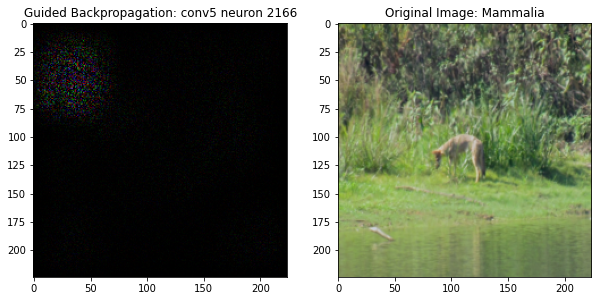

  0%|          | 35/8999 [00:01<08:29, 17.60it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Mammalia


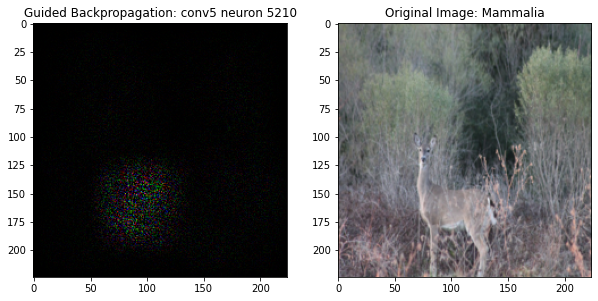

  2%|▏         | 181/8999 [00:05<03:32, 41.58it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Fungi


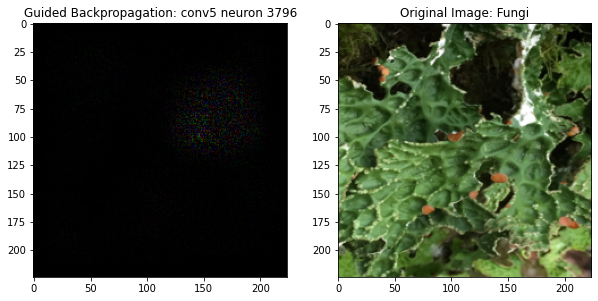

  2%|▏         | 220/8999 [00:07<04:12, 34.77it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Fungi


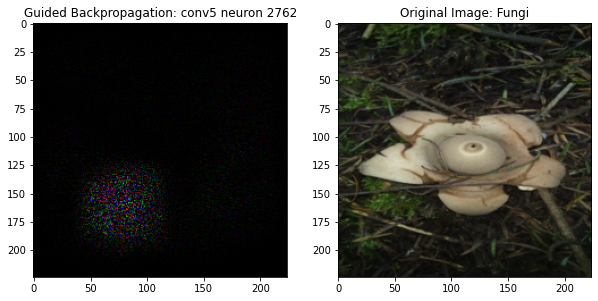

  3%|▎         | 228/8999 [00:07<07:46, 18.81it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Amphibia


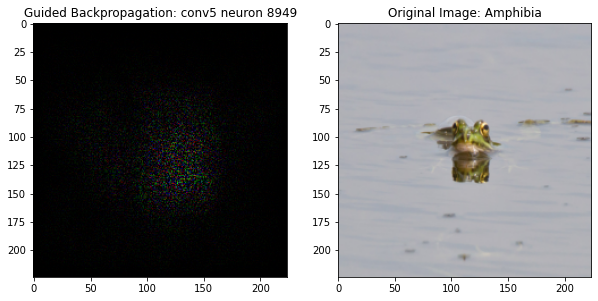

  3%|▎         | 247/8999 [00:08<06:09, 23.68it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Plantae


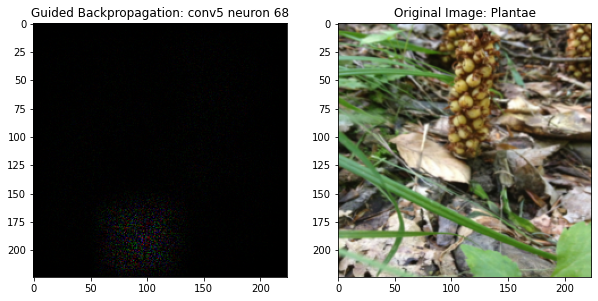

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Plantae


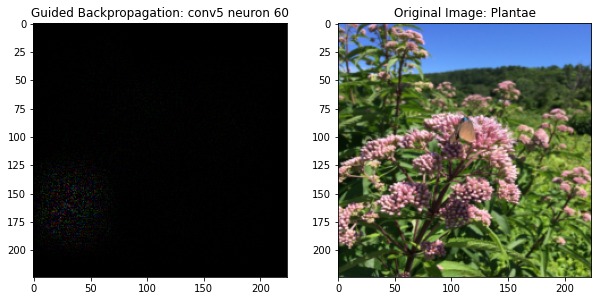

  3%|▎         | 258/8999 [00:10<11:02, 13.20it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Animalia


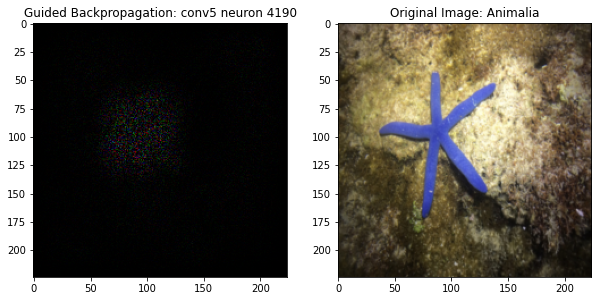

  3%|▎         | 284/8999 [00:11<05:26, 26.68it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Fungi


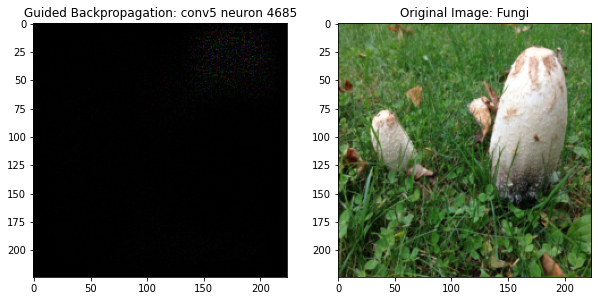

  3%|▎         | 311/8999 [00:12<04:50, 29.87it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Fungi


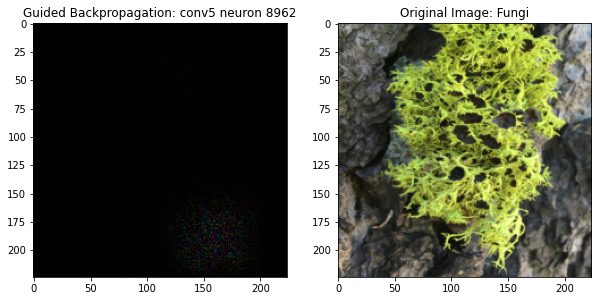

  3%|▎         | 314/8999 [00:13<06:12, 23.31it/s]


In [21]:
def plot_maps(img1, img2, neuron_idx, label, vmin=0.3,vmax=0.7, mix_val=2):
    fig, axs = plt.subplots(1, 2, figsize=(10, 30))
    axs[0].imshow(img1,vmin=vmin, vmax=vmax )#, cmap="gray")
    axs[0].set_title(f'Guided Backpropagation: conv5 neuron {neuron_idx}')
    axs[1].imshow(img2)#, cmap="gray")
    axs[1].set_title(f'Original Image: {label}')
    plt.show()

def norm_flat_image(img):
    # grads_norm = prep_output(img)
    grads_norm = img[:,:,0]+ img[:,:,1]+ img[:,:,2]
    grads_norm = grads_norm.cpu().detach().numpy()
    grads_norm = (grads_norm - np.min(grads_norm))/ (np.max(grads_norm)- np.min(grads_norm))
    return grads_norm

def relu_hook_function(module, grad_in, grad_out):
    if isinstance(module, torch.nn.ReLU):
        return (torch.clamp(grad_in[0], min=0.),)

train_loader, valid_loader = create_data("train",train_data_path,False,image_shape[2:], 1)
idx2classes = {v: k for k, v in train_loader.dataset.class_to_idx.items()}

for i, module in enumerate(model.modules()):
    if isinstance(module, torch.nn.ReLU):
        print(model.named_modules())
        module.register_backward_hook(relu_hook_function)

neuron_idxs = []

for imgs, targets in tqdm(train_loader):
  img, target = imgs[:1].to(device), targets[:1].to(device)
  img.requires_grad = True

  imgs, targets = imgs.to(device), targets.to(device)
  scores = model(imgs)
  _, predictions = scores.max(1)
  correct_samples = int(sum(predictions == targets))
  
  if correct_samples < 1:
    continue

  label = idx2classes[int(predictions[0].cpu().detach().numpy())]
  print(label)

  # forward/inference
  out = model.conv_blocks(img)
  if out.argmax() in neuron_idxs:
    continue

  neuron_idx = out.argmax()
  neuron_idxs.append(neuron_idx)
  out[out == out.max()].backward()
  grads = img.grad
  # plot_maps(norm_flat_image(grads[0].permute(1,2,0)),norm_flat_image(img[0].permute(1,2,0)), neuron_idx, label)
  plot_maps(grads[0].permute(1,2,0).cpu().detach().numpy(),img[0].permute(1,2,0).cpu().detach().numpy(), neuron_idx, label)
  
  if len(neuron_idxs) == 10:
    break